# Fraud Detection

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

## Import data

In [2]:
df = pd.read_csv("data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Dataset Splitting

In [3]:
X = df.drop(columns="Class")
y = df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24393, 30), (6099, 30), (24393,), (6099,))

## Quick EDA

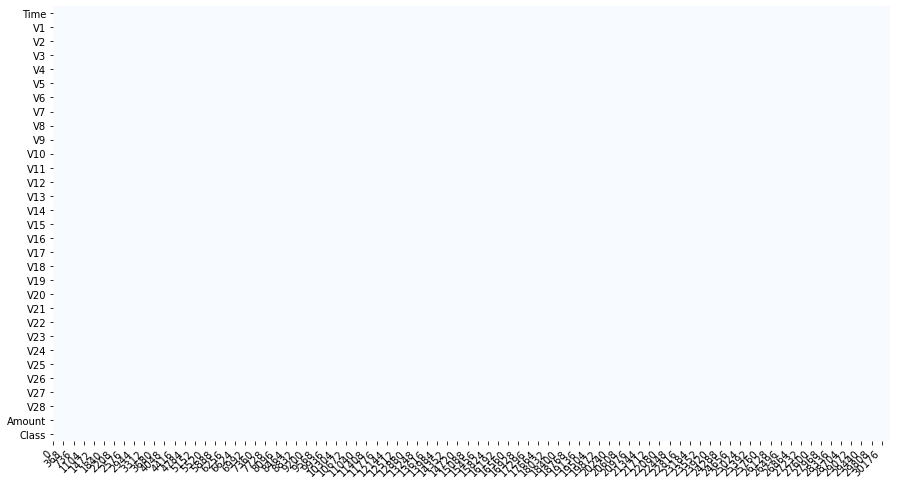

In [4]:
plot_missing_value(df)

## Training

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [6]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), X_train.columns),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])



model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:  1.4min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 1000.0, 'algo__gamma': 0.001}
0.999385069487148 0.9986471528717256 0.9996720773897361


hasilnya sangat bagus, namun bila hasil mendekati 100% ada beberap hal yang harus diwaspadai dan dicurigai,  

- apakah terdapat data leakage
- apakah datasetnya imbalance
- apakah memang problemnya sesuartu yang sederhana

In [7]:
df.Class.value_counts()

0    30000
1      492
Name: Class, dtype: int64

terlihat bahwa data kita imbalance untuk kolom class, yang melakukan kecurangan kartu kredit hanya 492 dan yang tidak melakukan kecurangan kartu kredit ada 30000  

untuk itu untuk data imblance kita bisa menggunakan metrik scoring lain, bukan menggunakan akurasi karena bisa mengecoh, tetapi menggunakan f1 scoring. scoring f1 akan mempertimbangkan data yang imbalance dalam penscoringan

In [8]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), X_train.columns),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])



model = GridSearchCV(pipeline, gsp.svm_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:  1.4min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 1000.0, 'algo__gamma': 0.001}
0.980595084087969 0.9574909514939499 0.9896907216494846


In [9]:
from jcopml.plot import plot_confusion_matrix

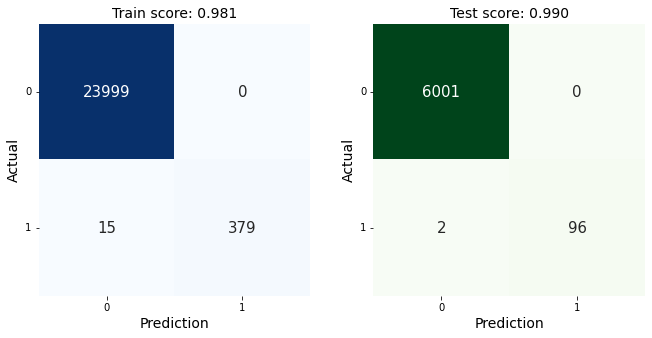

In [10]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

confusion matrix akan memplot data actual dan prediction

caranya membacanya adalah :  
` sumbu 0 dan 1 pada sumbu x dan y adalah data sebenearnya dimana 0 adalah jujur dan adalah curang, jadi di sumbu 1, 0 adalah ketika model nmemprediksi bahwa suatu data curang tetapi pada data asli tidak curang`

data train :
- terdapat 23999 data yang kita berhasil preediksi dengan benar bahwa pada data asli tidak curang dan pada prediksi juga menyatakan tidak curang
- terdapat 15 data yang di data asli sebenarnya curang tetapi di prediksi tidak curang
- terdapat 0 data dimana prediksi menyatakan curang tetapi di data asli tidak curang
- terdapat 389 data dmana data asli curang dan data prediksi juga curang

data test :
- terdapat 6001 data yang kita berhasil preediksi dengan benar bahwa pada data asli tidak curang dan pada prediksi juga menyatakan tidak curang
- terdapat 2 data yang di data asli sebenarnya curang tetapi di prediksi tidak curang
- terdapat 0 data dimana prediksi menyatakan curang tetapi di data asli tidak curang
- terdapat 96 data dimana data asli curang dan data prediksi juga curang

### Coba improve pakai class weight (Feature engineering untuk data imbalance)

# pembobotan, data curang bobotnya dibuat lebih besar, karena data curang yang lebih sedikit

{0:0.05 , 1:0.095}   
{0:0.1 , 1:0.9}  
{0:0.25 , 1:0.75}  

algo__gamma bisa kita ganti dengan bantuan numpy

In [11]:
np.logspace(-3, 3, 7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

algo__class_weight bisa kita ganti dengan cara dibuat dalam bentuk list comprehension dalam bentuk looping

In [12]:
[{0: x, 1:1-x} for x in [0.05, 0.1, 0.25]]

[{0: 0.05, 1: 0.95}, {0: 0.1, 1: 0.9}, {0: 0.25, 1: 0.75}]

In [45]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), X_train.columns),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

parameter = {
    'algo__gamma': np.logspace(-3, 3, 7),
     'algo__C': np.logspace(-3, 3, 7),
     'algo__class_weight': [{0: x, 1:1-x} for x in [0.05, 0.1, 0.25]]
    }

model = GridSearchCV(pipeline, parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 147 candidates, totalling 441 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 441 out of 441 | elapsed:  4.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 100.0, 'algo__class_weight': {0: 0.1, 1: 0.9}, 'algo__gamma': 0.01}
0.9997540277948592 0.9987701389742959 0.9991801934743401
